# Split patchlets for k-fold cross-validation

```
#
# Copyright (c) Sinergise, 2019 -- 2021.
#
# This file belongs to subproject "field-delineation" of project NIVA (www.niva4cap.eu).
# All rights reserved.
#
# This source code is licensed under the MIT license found in the LICENSE
# file in the root directory of this source tree.
#
```

This notebook:

 * loads the dataframe with the patchlets descriptions
 * splits the eopatches and corresponding patchlets into k-folds
 * updates the info csv file with fold information

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
from functools import partial

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 

from fd.utils import multiprocess, prepare_filesystem
from fd.training import SplitConfig, fold_split

# Basic config 

In [3]:
split_config = SplitConfig(
    bucket_name='bucket-name',
    aws_access_key_id='',
    aws_secret_access_key='',
    aws_region='eu-central-1',
    metadata_path='metadata/Castilla/2020-04/patchlet-info.csv',
    npz_folder='data/Castilla/2020-04/patchlets_npz',
    n_folds=5)

In [4]:
filesystem = prepare_filesystem(split_config)

### Load patchlets metadata 

In [5]:
df = pd.read_csv(filesystem.open(split_config.metadata_path))

In [6]:
df.head()

,chunk,eopatch,patchlet,chunk_pos,timestamp,mean_b0,mean_b1,mean_b2,mean_b3,std_b0,...,norm_meanstd_mean_b2,norm_meanstd_mean_b3,norm_meanstd_median_b0,norm_meanstd_median_b1,norm_meanstd_median_b2,norm_meanstd_median_b3,norm_meanstd_std_b0,norm_meanstd_std_b1,norm_meanstd_std_b2,norm_meanstd_std_b3
0,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_0,0,2020-03-25,946.885086,903.584335,782.504227,2508.395584,149.192150,...,1014.02099,2746.590043,1017.891939,995.769063,933.1703,2726.109618,175.795333,232.388964,382.406135,649.973699
1,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_0,1,2020-03-27,1052.747513,1001.685013,879.340103,2822.341324,161.609392,...,1014.02099,2746.590043,1017.891939,995.769063,933.1703,2726.109618,175.795333,232.388964,382.406135,649.973699
2,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_1,2,2020-03-25,951.282150,915.464325,789.655685,2611.258011,142.239637,...,1014.02099,2746.590043,1017.891939,995.769063,933.1703,2726.109618,175.795333,232.388964,382.406135,649.973699
3,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_1,3,2020-03-27,1053.198975,1013.473846,880.672379,2945.391541,151.519767,...,1014.02099,2746.590043,1017.891939,995.769063,933.1703,2726.109618,175.795333,232.388964,382.406135,649.973699
4,patchlets_field_delineation_0.npz,29TPE_8_0,data/Castilla/2020-04/patchlets/29TPE_8_0_2,4,2020-03-25,907.313629,854.274582,729.555573,2400.836746,89.188441,...,1014.02099,2746.590043,1017.891939,995.769063,933.1703,2726.109618,175.795333,232.388964,382.406135,649.973699


### Create n-fold datasets

TODO: improve split for overlapping EOPatches, e.g. from different UTMs. ATM this is not taken into consideration.

In [7]:
eops = df.eopatch.unique()

np.random.seed(seed=split_config.seed)
fold = np.random.randint(1, high=split_config.n_folds+1, size=len(eops))
eopatch_to_fold_map = dict(zip(eops, fold))

df['fold'] = df['eopatch'].apply(lambda x: eopatch_to_fold_map[x])

In [8]:
for nf in range(split_config.n_folds):
    print(f'{len(df[df.fold==nf+1])} patchlets in fold {nf+1}')

4128 patchlets in fold 1
3536 patchlets in fold 2
3525 patchlets in fold 3
3855 patchlets in fold 4
3657 patchlets in fold 5


Visualise on grid definition

In [9]:
gdf = gpd.read_file('../../input-data/cyl-grid-definition.gpkg')

In [10]:
gdf.head()

,id,name,geometry
0,2302137,30TVM_2_5,"POLYGON ((-3.96458 41.90790, -3.96594 41.99795..."
1,2301391,30TUN_7_8,"POLYGON ((-4.58294 42.53146, -4.58522 42.62148..."
2,2301392,30TUN_7_9,"POLYGON ((-4.58067 42.44143, -4.58294 42.53146..."
3,2301398,30TUN_8_5,"POLYGON ((-4.46755 42.80315, -4.46969 42.89318..."
4,2301399,30TUN_8_6,"POLYGON ((-4.46543 42.71313, -4.46755 42.80315..."


Not all eopatches generate patchlets due to lack of reference labels or cloud coverage, so there are less eopatches used for training than the total

In [11]:
len(eops), len(gdf)

(881, 1083)

In [12]:
gdf_training = gdf[gdf['name'].isin(eops)]

In [13]:
gdf_training['fold'] = gdf_training.name.apply(lambda x: eopatch_to_fold_map[x])

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


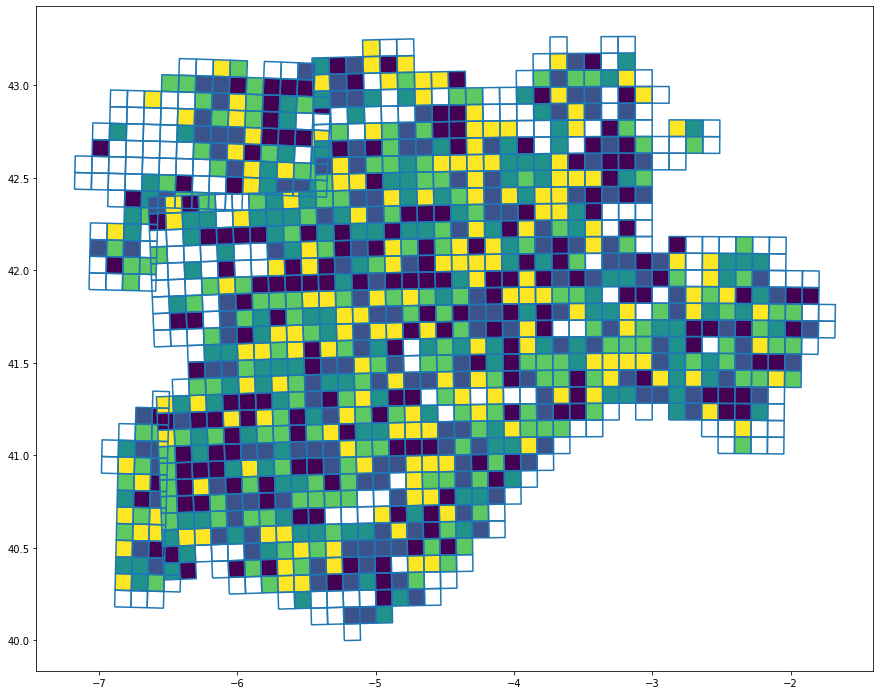

In [14]:
fig, ax = plt.subplots(figsize=(15, 15))
gdf_training.plot(ax=ax, column='fold')
gdf.boundary.plot(ax=ax)

## Create fold directories and npz files

The previously generated `.npz` files are split into folds according to the fold assigned in the dataframe. New `fold_X` folders are created where the new files are saved to.

In [15]:
partial_fn = partial(fold_split, df=df, config=split_config)

In [16]:
npz_files = filesystem.listdir(split_config.npz_folder)

Remove possible folders from list

In [17]:
npz_files = [npzf for npzf in npz_files if npzf.startswith('patchlets_')]

In [18]:
len(npz_files)

375

In [ ]:
_ = multiprocess(partial_fn, npz_files, max_workers=20)

Update `.csv` file with fold information

In [26]:
with filesystem.open(split_config.metadata_path, 'w') as fcsv:
    df.to_csv(fcsv, index=False)

##### Check results with some sanity checks 

In [23]:
for fold in range(1, split_config.n_folds+1):
    
    fold_folder = os.path.join(split_config.npz_folder, f'fold_{fold}')

    for i in [7, 50, 154, 176, 185]: 
        chunk = f'patchlets_field_delineation_{i}.npz'

        data = np.load(filesystem.openbin(os.path.join(fold_folder, chunk)))

        fold_df = df[(df.chunk == chunk) & (df.fold == fold)]
        
        assert len(fold_df.chunk_pos) == data['y_boundary'].shape[0]
        assert len(fold_df.chunk_pos) == data['y_extent'].shape[0]
        assert len(fold_df.chunk_pos) == data['y_distance'].shape[0]
        assert len(fold_df.chunk_pos) == data['X'].shape[0]
        
        print(f"For fold_{fold}/{chunk} the lengths match.")

For fold_1/patchlets_field_delineation_7.npz the lengths match.
For fold_1/patchlets_field_delineation_50.npz the lengths match.
For fold_1/patchlets_field_delineation_154.npz the lengths match.
For fold_1/patchlets_field_delineation_176.npz the lengths match.
For fold_1/patchlets_field_delineation_185.npz the lengths match.
For fold_2/patchlets_field_delineation_7.npz the lengths match.
For fold_2/patchlets_field_delineation_50.npz the lengths match.
For fold_2/patchlets_field_delineation_154.npz the lengths match.
For fold_2/patchlets_field_delineation_176.npz the lengths match.
For fold_2/patchlets_field_delineation_185.npz the lengths match.
For fold_3/patchlets_field_delineation_7.npz the lengths match.
For fold_3/patchlets_field_delineation_50.npz the lengths match.
For fold_3/patchlets_field_delineation_154.npz the lengths match.
For fold_3/patchlets_field_delineation_176.npz the lengths match.
For fold_3/patchlets_field_delineation_185.npz the lengths match.
For fold_4/patchlet